<a href="https://colab.research.google.com/github/pvdklei/modelsmakemodels/blob/master/ThijsDenoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import tensorflow as tf
import tensorboard as tb

import matplotlib.pyplot as plt
import numpy as np

In [4]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.CIFAR10("/data/cifar10/train", train=True,
                                   download=True, transform=transform)
test_data = datasets.CIFAR10("/data/cifar10/test", train=False,
                                  download=True, transform=transform)

# Create training and test dataloaders
num_workers = 2
# how many samples per batch to load
batch_size = 6

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


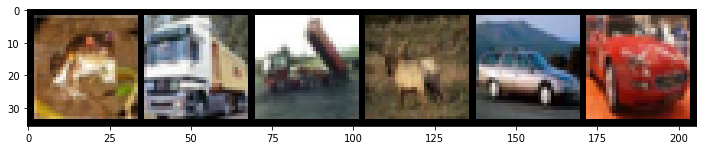

In [7]:
def showimage(image):
    image = image.numpy()
    image = image.transpose((1, 2, 0))
    plt.figure(figsize = (12,12))
    plt.imshow(image)

images, labels = next(iter(train_loader))
showimage(torchvision.utils.make_grid(images))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()

        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
              
        return x

# initialize the NN
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [9]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
# number of epochs to train the model
n_epochs = 20
MSEloss = []

# for adding noise to images
noise_factor=0.25

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        MSEloss.append(train_loss)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.380630
Epoch: 2 	Training Loss: 0.379057


In [13]:
print(MSEloss)

[tensor(0.0735, grad_fn=<MseLossBackward>), tensor(0.0687, grad_fn=<MseLossBackward>), tensor(0.0760, grad_fn=<MseLossBackward>), tensor(0.0733, grad_fn=<MseLossBackward>), tensor(0.0720, grad_fn=<MseLossBackward>), tensor(0.0543, grad_fn=<MseLossBackward>), tensor(0.0577, grad_fn=<MseLossBackward>), tensor(0.0535, grad_fn=<MseLossBackward>), tensor(0.0696, grad_fn=<MseLossBackward>), tensor(0.0713, grad_fn=<MseLossBackward>), tensor(0.0584, grad_fn=<MseLossBackward>), tensor(0.0585, grad_fn=<MseLossBackward>), tensor(0.0551, grad_fn=<MseLossBackward>), tensor(0.0528, grad_fn=<MseLossBackward>), tensor(0.0668, grad_fn=<MseLossBackward>), tensor(0.0530, grad_fn=<MseLossBackward>), tensor(0.0732, grad_fn=<MseLossBackward>), tensor(0.0960, grad_fn=<MseLossBackward>), tensor(0.0494, grad_fn=<MseLossBackward>), tensor(0.0702, grad_fn=<MseLossBackward>), tensor(0.0642, grad_fn=<MseLossBackward>), tensor(0.0675, grad_fn=<MseLossBackward>), tensor(0.0776, grad_fn=<MseLossBackward>), tensor(0.0

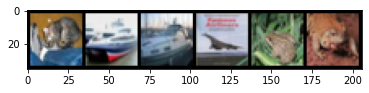

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
showimage(torchvision.utils.make_grid(images))

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


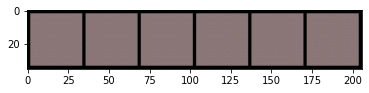

In [ ]:
# get sample outputs
output = model(noisy_imgs)

# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 3, 32, 32)
# use detach when it's an output that requires_grad
output = output.detach().numpy()
output = torch.from_numpy(output)
showimage(torchvision.utils.make_grid(output))

In [ ]:
# reconstruction accuracy